## Project 4: West Nile Virus Prediction
------------------------------------------------------------------------------------------------------------------------
## Part 1a. Train, Test Data EDA & Cleaning
Group 2 (Edmund, Marc, Mingzi, Rohazeanti), SG DSIF5 

### Problem statement

West Nile virus (WNV) is the leading cause of mosquito-borne disease in the continental United States.  It is most commonly spread to people by the bite of an infected mosquito. Cases of WNV occur during mosquito season, which starts in the summer and continues through fall. There are no vaccines to prevent or medications to treat WNV in people. In this project, we are provided with mosquito trapping, weather, location and fumigation datasets to predict WNV outbreaks in the City of Chicago for effective resources spending on the prevention of this virus.

## Table of Contents
- [Importing the libraries](#Importing-the-libraries)
- [Importing the datasets](#Importing-the-datasets)
- [Inspect Data](#Inspect-Data)
- [Data Cleaning](#Data-Cleaning)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)

### Importing the libraries

In [71]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import pickle

import plotly.express as px
import calmap
import scipy.stats as stats

from collections import Counter

import haversine as hs
from haversine import Unit

pd.set_option("display.max_columns", None)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Importing the datasets

In [72]:
spray = pd.read_csv("./data/spray.csv")
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")
weather = pd.read_csv("./data/weather.csv")

### Inspect Data

In [73]:
def basic_eda(df, df_name):
    print("-----",df_name.upper(), "-----\n")
    print(f"Rows: {df.shape[0]} \t Columns: {df.shape[1]}\n")
    
    print(f"Total null rows: {df.isnull().sum().sum()}")
    print(f"Percentage of null rows: {round(df.isnull().sum().sum() / df.shape[0] * 100, 2)}% \n")
    
    print(f"Total duplicate rows: {df[df.duplicated(keep=False)].shape[0]}")
    print(f"Percentage of duplicated rows: {round(df[df.duplicated(keep=False)].shape[0] / df.shape[0] * 100, 2)}% \n")
    
    print(df.info())
    print("\n")

In [74]:
dfs = [
    (train, 'train'),
    (spray, 'spray'),
    (weather, 'weather'),
    (test, 'test')
    ]

In [75]:
[basic_eda(df, name) for df, name in dfs]

----- TRAIN -----

Rows: 10506 	 Columns: 12

Total null rows: 0
Percentage of null rows: 0.0% 

Total duplicate rows: 1062
Percentage of duplicated rows: 10.11% 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Date                    10506 non-null  object 
 1   Address                 10506 non-null  object 
 2   Species                 10506 non-null  object 
 3   Block                   10506 non-null  int64  
 4   Street                  10506 non-null  object 
 5   Trap                    10506 non-null  object 
 6   AddressNumberAndStreet  10506 non-null  object 
 7   Latitude                10506 non-null  float64
 8   Longitude               10506 non-null  float64
 9   AddressAccuracy         10506 non-null  int64  
 10  NumMosquitos            10506 non-null  int64  
 11  WnvPresent              10506 non

[None, None, None, None]

### Data Cleaning

#### Define functions for cleaning data

In [76]:
# Create 4 new columns: Year, Month, Day, Week from the Date column
def create_yr_day_mth(df): 
    df['Year'] = [dd.year for dd in pd.DatetimeIndex(df.Date.values)]
    df['Month'] = [dd.month for dd in pd.DatetimeIndex(df.Date.values)]
    df['Day'] = [dd.day for dd in pd.DatetimeIndex(df.Date.values)]
    df['Week'] = [dd.week for dd in pd.DatetimeIndex(df.Date.values)]
    return df

# Convert the Date into datetime format
def convert_date(df): 
    df['Date'] = pd.to_datetime(df['Date'])
    df.sort_values(by='Date',ascending=True,inplace=True)
    df.reset_index(drop=True,inplace=True)
    return df

#find min and max date
def min_max_date(df, df_name):
    print("-----",df_name.upper(), "-----\n")
    print("Earliest record: ", df.Date.min(),
      "\nLatest Record: ", df.Date.max(), "\n")
    print(df['Year'].unique(),"\n")
    
def whitespace_remover(dataframe):
   
    # iterating over the columns
    for i in dataframe.columns:
         
        # checking datatype of each columns
        if dataframe[i].dtype == 'object':
             
            # applying strip function on column
            dataframe[i] = dataframe[i].map(str.strip)
        else:
             
            # if condn. is False then it will do nothing.
            pass

In [77]:
# Let us remove whitespace from Train, test, weather dataframes
whitespace_remover(train)
whitespace_remover(test)
whitespace_remover(weather)

In [78]:
# Convert datetime format for train, test, weather, spray dataframes
train = convert_date(train)
test = convert_date(test)
weather = convert_date(weather)
spray = convert_date(spray)

In [79]:
train.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
1,2007-05-29,"8900 South Carpenter Street, Chicago, IL 60620...",CULEX RESTUANS,89,S CARPENTER ST,T159,"8900 S CARPENTER ST, Chicago, IL",41.732984,-87.649642,8,1,0
2,2007-05-29,"1500 North Long Avenue, Chicago, IL 60651, USA",CULEX RESTUANS,15,N LONG AVE,T153,"1500 N LONG AVE, Chicago, IL",41.907645,-87.760886,8,1,0
3,2007-05-29,"7500 North Oakley Avenue, Chicago, IL 60645, USA",CULEX PIPIENS/RESTUANS,75,N OAKLEY AVE,T148,"7500 N OAKLEY AVE, Chicago, IL",42.017430,-87.687769,8,1,0
4,2007-05-29,"6500 North Oak Park Avenue, Chicago, IL 60631,...",CULEX PIPIENS/RESTUANS,65,N OAK PARK AVE,T143,"6500 N OAK PARK AVE, Chicago, IL",41.999129,-87.795585,8,1,0


In [80]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Block,10506.0,35.687797,24.339468,10.000000,12.000000,33.000000,52.000000,98.000000
Latitude,10506.0,41.841139,0.112742,41.644612,41.732984,41.846283,41.954690,42.017430
Longitude,10506.0,-87.699908,0.096514,-87.930995,-87.760070,-87.694991,-87.627796,-87.531635
AddressAccuracy,10506.0,7.819532,1.452921,3.000000,8.000000,8.000000,9.000000,9.000000
NumMosquitos,10506.0,12.853512,16.133816,1.000000,2.000000,5.000000,17.000000,50.000000
WnvPresent,10506.0,0.052446,0.222936,0.000000,0.000000,0.000000,0.000000,1.000000


In [81]:
test.head()

,Id,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy
0,1,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9
1,809,2008-06-11,"3700 118th Street, Chicago, IL 60617, USA",CULEX PIPIENS/RESTUANS,37,E 118TH ST,T212,"3700 E 118TH ST, Chicago, IL",41.680946,-87.535198,8
2,808,2008-06-11,"South Brandon Avenue, Chicago, IL 60617, USA",CULEX ERRATICUS,13,S BRANDON,T209,"1300 S BRANDON, Chicago, IL",41.740641,-87.546587,5
3,807,2008-06-11,"South Brandon Avenue, Chicago, IL 60617, USA",UNSPECIFIED CULEX,13,S BRANDON,T209,"1300 S BRANDON, Chicago, IL",41.740641,-87.546587,5
4,806,2008-06-11,"South Brandon Avenue, Chicago, IL 60617, USA",CULEX TARSALIS,13,S BRANDON,T209,"1300 S BRANDON, Chicago, IL",41.740641,-87.546587,5


In [82]:
# Reset the index for train dataset based on the Id
test = test.sort_values(by='Id',ascending=True).reset_index(drop=True)

### `Train` Dataset

- This dataset contain 10506 rows and 12 columns (+4 date columns that we have extracted)
- There are no null values present in this dataset. 

In [83]:
train.columns

Index(['Date', 'Address', 'Species', 'Block', 'Street', 'Trap',
       'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy',
       'NumMosquitos', 'WnvPresent'],
      dtype='object')

In [84]:
train.shape

(10506, 12)

#### Combine number of mosquitos
- As the test results are organized in such a way that when the number of mosquitos exceed 50, they are split into another record (another row in the dataset), such that the number of mosquitos are capped at 50. This can be seen in the data description above earlier that the max for `NumMosquitos` is 50.
- These records will be combined into a single record

In [85]:
train = train.groupby(['Date', 'Address', 'Species', 'Block', 'Street', 'Trap',
       'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy',
       'WnvPresent']).agg({'NumMosquitos': 'sum'}).reset_index()

In [86]:
train.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,WnvPresent,NumMosquitos
0,2007-05-29,"1100 Roosevelt Road, Chicago, IL 60608, USA",CULEX PIPIENS/RESTUANS,11,W ROOSEVELT,T048,"1100 W ROOSEVELT, Chicago, IL",41.867108,-87.654224,8,0,1
1,2007-05-29,"1100 Roosevelt Road, Chicago, IL 60608, USA",CULEX RESTUANS,11,W ROOSEVELT,T048,"1100 W ROOSEVELT, Chicago, IL",41.867108,-87.654224,8,0,2
2,2007-05-29,"1100 South Peoria Street, Chicago, IL 60608, USA",CULEX RESTUANS,11,S PEORIA ST,T091,"1100 S PEORIA ST, Chicago, IL",41.862292,-87.648860,8,0,1
3,2007-05-29,"1100 West Chicago Avenue, Chicago, IL 60642, USA",CULEX RESTUANS,11,W CHICAGO,T049,"1100 W CHICAGO, Chicago, IL",41.896282,-87.655232,8,0,1
4,2007-05-29,"1500 North Long Avenue, Chicago, IL 60651, USA",CULEX RESTUANS,15,N LONG AVE,T153,"1500 N LONG AVE, Chicago, IL",41.907645,-87.760886,8,0,1


In [87]:
# Let us check the shape of the train dataset after groupby
train.shape

(8610, 12)

- After combining the number of mosquitos, the number of rows has been reduced to 8610

In [88]:
# Check for duplicates
train[train.duplicated(keep = False)]

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,WnvPresent,NumMosquitos


In [89]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Block,8610.0,38.793380,24.129378,10.000000,14.000000,37.000000,58.000000,98.000000
Latitude,8610.0,41.844422,0.107076,41.644612,41.750498,41.857402,41.944869,42.017430
Longitude,8610.0,-87.695237,0.084921,-87.930995,-87.752411,-87.694991,-87.642984,-87.531635
AddressAccuracy,8610.0,7.936121,1.326695,3.000000,8.000000,8.000000,9.000000,9.000000
WnvPresent,8610.0,0.053078,0.224202,0.000000,0.000000,0.000000,0.000000,1.000000
NumMosquitos,8610.0,15.683972,68.560634,1.000000,2.000000,4.000000,11.000000,2206.000000


- The max number of NumMosquitos is now 2206.

### `Test` Dataset
- `Test` dataset contains 116293 rows and 11 columns
- There are no missing values

In [90]:
test.shape

(116293, 11)

In [91]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116293 entries, 0 to 116292
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   Id                      116293 non-null  int64         
 1   Date                    116293 non-null  datetime64[ns]
 2   Address                 116293 non-null  object        
 3   Species                 116293 non-null  object        
 4   Block                   116293 non-null  int64         
 5   Street                  116293 non-null  object        
 6   Trap                    116293 non-null  object        
 7   AddressNumberAndStreet  116293 non-null  object        
 8   Latitude                116293 non-null  float64       
 9   Longitude               116293 non-null  float64       
 10  AddressAccuracy         116293 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(5)
memory usage: 9.8+ MB


### Exploratory Data Analysis
- The following EDA will be done only on Train Dataset

Create Day Month Year Week columns for Train, Test dataset

In [92]:
# Split the date in the train dataset into Year, Month, Day, Week
train = create_yr_day_mth(train)
# Split the date in the test dataset into Year, Month, Day, Week
test = create_yr_day_mth(test)

#### Mosquito Traps and Trap locations
The following EDA will be performed 
- Heat map on Data collection date
- No. of traps and location
- Duplicate of Trap ID
- Sampling frequencies of Traps and no. of traps sampled per year
- Traps location
- Virus detected in mosquito
- Location of virus detected

In [93]:
#Total number of mosquito captured = 135039
train['NumMosquitos'].sum()

135039

In [94]:
#Check for imbalanced class
train['WnvPresent'].value_counts(normalize = True)

0    0.946922
1    0.053078
Name: WnvPresent, dtype: float64

- WnvPresent is our target class and one class label has a very high number of observations and the other has a very low number of observations. The proportion of observations with "No Wnv" is ~94.7% while "Have Wnv" is 5.3%. This imbalance is quite acute where the majority class’s presence is much higher than the minority class. 
- Due to the imbalance, we will apply appropriate technique for modelling. 

**Sampling Frequency**
- According to Centre for Disease Control and Prevention website[website](https://www.cdc.gov/westnile/index.html), cases of WNV occur during mosquito season, which starts in the summer and continues through fall.

C:\Users\rohaz\Anaconda3\lib\site-packages\seaborn\axisgrid.py:670: UserWarning:

Using the countplot function without specifying `order` is likely to produce an incorrect plot.



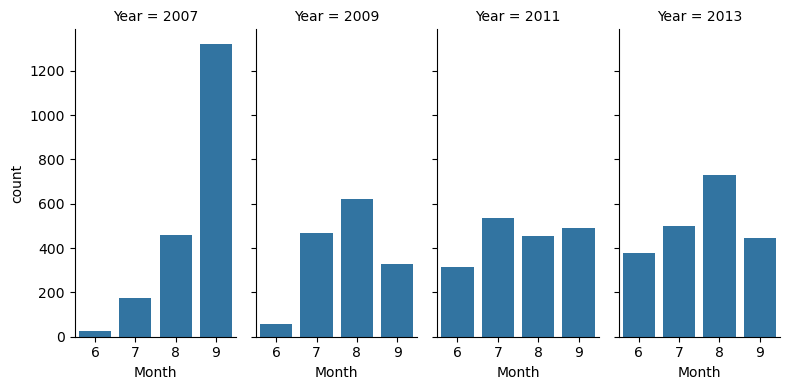

In [95]:
#Count plot of number of samplings collected by month
g = sns.FacetGrid(train, col="Year", height=4, aspect=.5)
g.map(sns.countplot, "Month");

- We can see here that sampling starts in May and ends in Oct

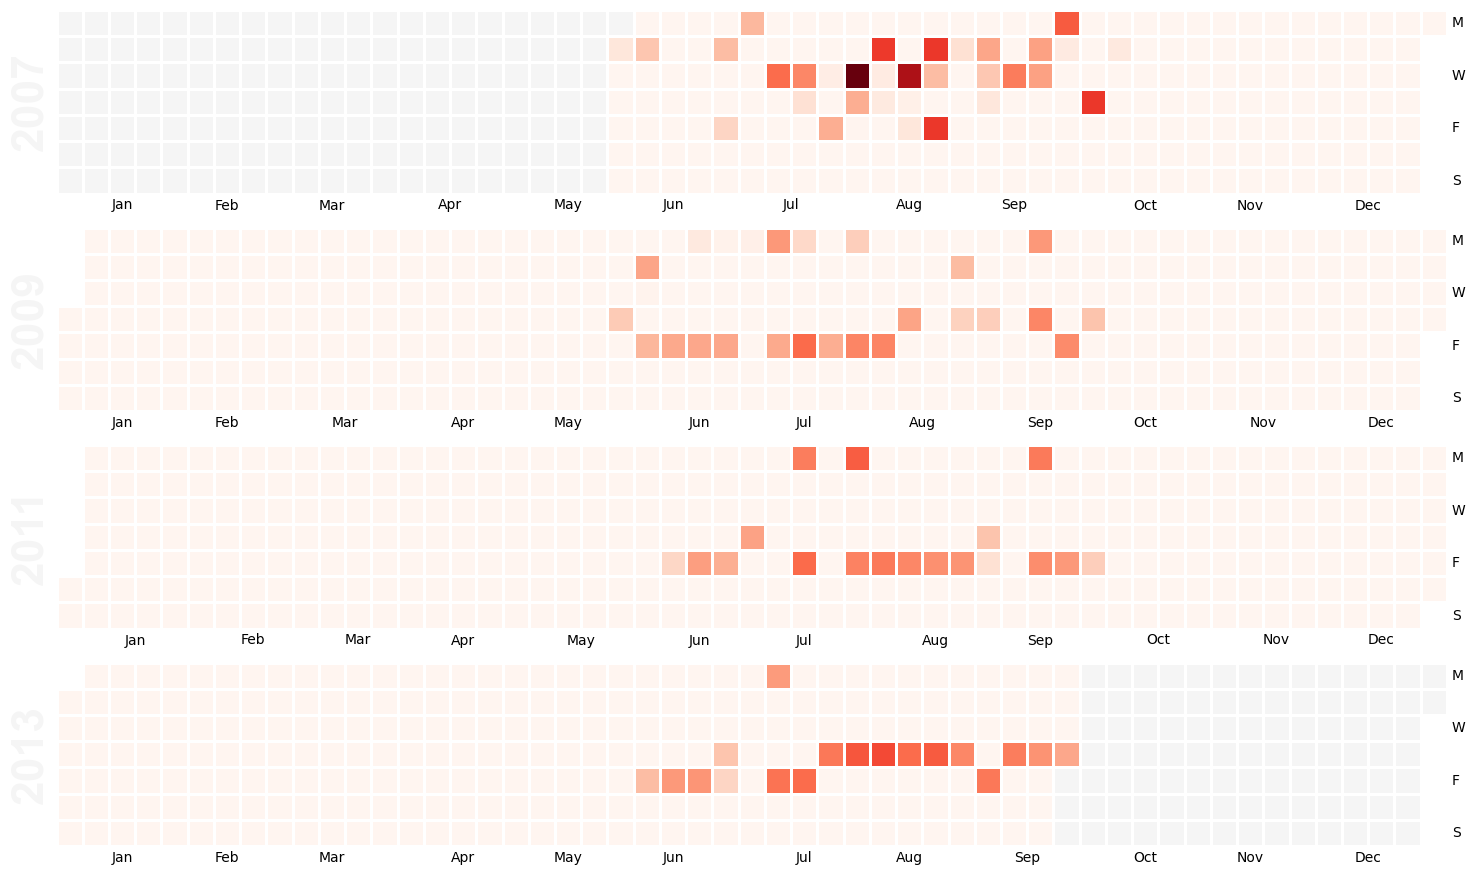

In [96]:
# Show heatmap calendar of data points in a day
days = train['Date'].values
events = pd.Series(np.ones(len(days)), index=days)
fig=calmap.calendarplot(events,daylabels='MTWTFSS',monthticks=1,
                        dayticks=[0, 2, 4, 6],
                        yearlabels=True, 
                        yearascending=True,
                        fig_kws={'figsize':(28,9)})

- It can be observed here that more samplings are collected in the heart of summer each year based on the intensity of the graph. 

**No. of traps and location**

In [97]:
#find number of Traps
print("There are ",train.Trap.nunique()," traps deployed")

There are  136  traps deployed


In [98]:
#Find top 10 traps with highest number of mosquito
train.groupby(['Trap'])['NumMosquitos'].sum().sort_values(ascending = False).head(10)

Trap
T115    21668
T900    15386
T138     9936
T002     3710
T128     3315
T135     3122
T103     2988
T008     2668
T212     2595
T158     2575
Name: NumMosquitos, dtype: int64

- T115 caught the highest number of mosquitos followed by T900 

In [99]:
#Top number of traps
train.groupby(['Trap','Latitude','Longitude'])['Trap'].count().sort_values(ascending = False).head(10)

Trap  Latitude   Longitude 
T900  41.974689  -87.890615    182
T115  41.673408  -87.599862    158
T135  41.662014  -87.724608    153
T002  41.954690  -87.800991    150
T151  41.916265  -87.800515    144
T031  41.801498  -87.763416    140
T048  41.867108  -87.654224    140
T138  41.726465  -87.585413    138
T090  41.868077  -87.666901    136
T054  41.921965  -87.632085    131
Name: Trap, dtype: int64

- Trap T900 were sampled 182 followed by T115.

In [100]:
#find total number of pairs of latitude and longitude
zipper = zip(train.Latitude, train.Longitude)
c = Counter(zipper)
print("There are a total of ",len(c),"pairs of longitude and latitude.")

There are a total of  138 pairs of longitude and latitude.


- Earlier we noted that there were 136 traps. Assuming that the relationship of trap to lair pf longitude/latitude is 1:1, I would expect the number of pairs of longitude/latitude to be 136 as well. However, that is not the case. There are additional 2 pairs of longitude/latitude. 
- This could mean that two Traps were deployed at two locations or were mislabelled. 

**Find Duplicate Trap ID**

In [101]:
for trap in list(train['Trap'].unique()):
    chk_trap = train[train['Trap']==trap][['Trap','Latitude','Longitude']].copy()
    chk_trap.drop_duplicates(['Trap','Latitude','Longitude'], keep='last', inplace=True)
    if len(chk_trap) > 1:
        display(chk_trap)

,Trap,Latitude,Longitude
2592,T009,41.981964,-87.812827
8590,T009,41.992478,-87.862995


,Trap,Latitude,Longitude
2695,T035,41.836644,-87.677737
8571,T035,41.763733,-87.742302


- Trap T009 and T035 seem to be deployed at two different location

In [102]:
train[train['Trap'] == 'T009'][['Year','AddressNumberAndStreet','Latitude','Longitude']].value_counts()

Year  AddressNumberAndStreet            Latitude   Longitude 
2013  9100  W HIGGINS RD, Chicago, IL   41.992478  -87.862995    33
2007  9100  W HIGGINS AVE, Chicago, IL  41.981964  -87.812827    27
2009  9100  W HIGGINS RD, Chicago, IL   41.992478  -87.862995    25
2011  9100  W HIGGINS RD, Chicago, IL   41.992478  -87.862995    12
dtype: int64

- In 2007, T009 were deployed at  9100  W HIGGINS AVE, Chicago, IL for 27 times and from 2009 onwards could have been relocated to  9100  W HIGGINS RD, Chicago, IL. 

In [103]:
train[train['Trap'] == 'T035'][['Year','AddressNumberAndStreet','Latitude','Longitude']].value_counts()

Year  AddressNumberAndStreet          Latitude   Longitude 
2007  3000  S HOYNE AVE, Chicago, IL  41.836644  -87.677737    27
2013  5100  W 72ND ST, Chicago, IL    41.763733  -87.742302    27
2011  5100  W 72ND ST, Chicago, IL    41.763733  -87.742302    18
dtype: int64

- Similarly for trap T035, in 2007, it was deployed at 3000  S HOYNE AVE, Chicago, IL for 27 times and on 2011 onwards, relocated to 5100  W 72ND ST, Chicago, IL. 

**Sampling frequencies of Traps and no. of traps sampled per year**

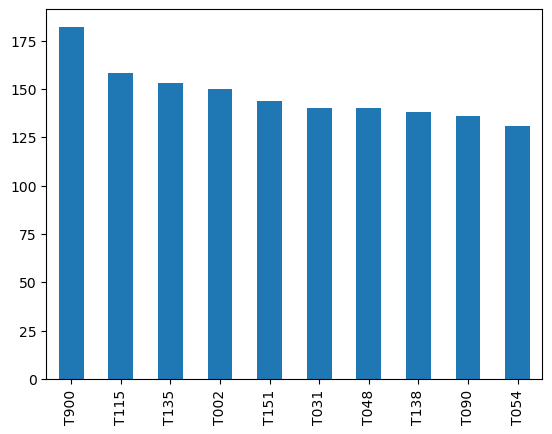

In [104]:
#Which mosquito traps are the most sampled
train['Trap'].value_counts().head(10).plot(kind = 'bar');

- T900 were sampled the most

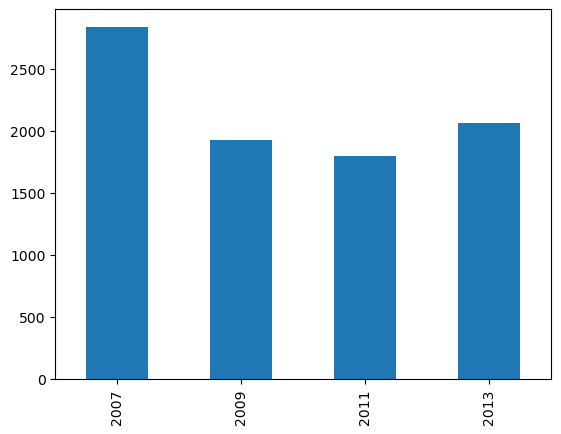

In [105]:
# Sampling frequencies per year
year_order = [2007, 2009, 2011, 2013]
train['Year'].value_counts().loc[year_order].plot(kind = 'bar');

- The most number of samples happen in 2007.

Let us explore using Plotly.express to create interactive map to show the location of the mosquitos, viruses and traps
<br><br>**Traps location**

In [106]:
# Trap location using Plotly express

MAPBOX_TOKEN = 'pk.eyJ1Ijoicm9oYXplYW50aSIsImEiOiJjbDd2ZDNqcXAwNGo2M29uMzl4NWFiMHpmIn0.fnjlOFn7S1HXMjC0Bakmqw'
px.set_mapbox_access_token(MAPBOX_TOKEN)
fig = px.scatter_mapbox(train, lat = 'Latitude', lon  = 'Longitude', size_max=15, zoom = 10)

fig.update_layout(title = 'Satellite Traps',
    autosize=False,
    width=600,
    height=600,)

fig.show()

**Virus detected in mosquito**

In [107]:
#To find the virus hotspot by AddressNumberAndStreet

# Group by address
mosquito_address = train.groupby(['AddressNumberAndStreet'], as_index = False)['NumMosquitos'].sum()
# Group by area
mosquito_area = train.groupby(['AddressNumberAndStreet'], as_index = False)['Latitude','Longitude'].median()
# Virus found in areas
virus = train.groupby(['AddressNumberAndStreet'], as_index = False)['WnvPresent'].sum()

#Create a dataframe with the virus hotspots
virus_hotspots = pd.concat([mosquito_area,mosquito_address,virus], axis = 1)
virus_hotspots.drop('AddressNumberAndStreet', axis = 1, inplace = True)

In [108]:
virus_hotspots.sort_values(by='NumMosquitos', ascending=False).head(10)

,Latitude,Longitude,NumMosquitos,WnvPresent
18,41.673408,-87.599862,21668,15
7,41.974689,-87.890615,15386,29
4,41.726465,-87.585413,9936,9
72,41.954690,-87.800991,3710,15
45,41.704572,-87.565666,3315,7
74,41.662014,-87.724608,3122,8
11,41.702724,-87.536497,2988,4
115,42.008314,-87.777921,2668,9
61,41.680946,-87.535198,2595,3
58,41.682587,-87.707973,2575,5


In [109]:
#To find the virus hotspot by Address

# total number of mosquitos in perticular area divided based on Address 
total_mosquito = train.groupby(['Address'], as_index = False)[['NumMosquitos']].sum()

# grouping areas based on 'Latitude'and 'Longitude' of the Address
areas = train.groupby(['Address'], as_index = False)[['Latitude','Longitude']].median()

# Number of virus found in these areas
virus = train.groupby(['Address'], as_index = False)[['WnvPresent']].sum() 

# creating a dataframe with total_mosquito, areas, virus as columns
exploratory_data = pd.concat([areas,total_mosquito, virus], axis = 1)

exploratory_data.drop('Address', axis = 1, inplace = True)
exploratory_data.sort_values(by='WnvPresent', ascending=False).head(10)

,Latitude,Longitude,NumMosquitos,WnvPresent
124,41.974689,-87.890615,15386,29
60,41.954690,-87.800991,3710,15
129,41.673408,-87.599862,21668,15
66,41.964242,-87.757639,1346,14
48,41.944869,-87.832763,1311,11
109,41.743402,-87.731435,2014,11
87,41.923738,-87.785288,1193,10
125,41.957799,-87.930995,2327,9
73,41.973845,-87.805059,1281,9
75,41.798697,-87.736812,2161,9


In [110]:
fig = px.scatter_mapbox(exploratory_data, lat = 'Latitude', lon  = 'Longitude', 
                        color = 'NumMosquitos', size = 'WnvPresent', 
                        color_continuous_scale=px.colors.sequential.Jet,
                        hover_data = ['NumMosquitos', 'WnvPresent'], zoom = 9)
fig.update_layout(title = 'No. of virus Vs mosquitos',
    autosize=False,
    width=600,
    height=600,)

fig.show()

The mosquito count and virus count are plotted on the map above with the following parameters:
- Color: Mosquito count
- Size: Viruses count

It can be seen that having a higher mosquito count does not equate to a higher West Nile Virus count. Percentage count of mosquitos having West Nile virus can be a good indicator to observe the virus in different location

**Virus hotspots**

In [111]:
virus_hotspots['VirusPercentage'] = virus_hotspots['WnvPresent']/virus_hotspots['NumMosquitos']

In [112]:
virus_hotspots.sort_values(by='VirusPercentage', ascending=False).head(10)

,Latitude,Longitude,NumMosquitos,WnvPresent,VirusPercentage
99,41.942114,-87.776385,50,2,0.040000
97,41.990284,-87.797127,107,4,0.037383
123,41.974089,-87.824812,169,4,0.023669
125,41.729669,-87.582699,86,2,0.023256
89,41.797616,-87.797894,90,2,0.022222
109,41.999129,-87.795585,230,5,0.021739
75,41.837085,-87.729384,52,1,0.019231
69,41.953067,-87.776792,58,1,0.017241
111,41.772846,-87.740029,61,1,0.016393
71,41.821582,-87.627796,207,3,0.014493


In [113]:
fig = px.scatter_mapbox(virus_hotspots, lat = 'Latitude', lon  = 'Longitude',
                        size = 'VirusPercentage',color = 'VirusPercentage', zoom = 9)

fig.update_layout(title = 'Percentage of Virus in different locations',
    autosize=False,
    width=600,
    height=600,)

fig.show()

### Mosquito species
The following EDA will be performed 
- Frequencies of Mosquito species captured
- Mosquitos captured per year
- Frequencies of WNV mosquitos captured per species
- WNV presence per year
- WNV presence per month

**Frequencies of Mosquito species captured**

In [114]:
# No. of times mosquito species got captured in trap
train['Species'].value_counts()

CULEX PIPIENS/RESTUANS    3899
CULEX RESTUANS            2409
CULEX PIPIENS             1996
CULEX TERRITANS            216
CULEX SALINARIUS            83
CULEX TARSALIS               6
CULEX ERRATICUS              1
Name: Species, dtype: int64

- CULEX PIPIENS/RESTUANS appears to be most common species caught

**Mosquitos captured per year**

In [115]:
#No of mosquito captured per year
train.groupby(['Species','Year'])['NumMosquitos'].sum().unstack()

Year,2007,2009,2011,2013
Species,,,,
CULEX ERRATICUS,NaN,NaN,NaN,7.0
CULEX PIPIENS,35871.0,867.0,1336.0,6597.0
CULEX PIPIENS/RESTUANS,20565.0,15531.0,11206.0,18966.0
CULEX RESTUANS,1847.0,4657.0,6068.0,10859.0
CULEX SALINARIUS,61.0,26.0,54.0,4.0
CULEX TARSALIS,NaN,2.0,5.0,NaN
CULEX TERRITANS,344.0,25.0,130.0,11.0


- Not all species were caught every year. 

In [116]:
#create a df to store total num of 'NumMosquitos','WnvPresent' group by 'Year','Species'
year_mozzie = train.groupby(['Year','Species'], as_index= False)['NumMosquitos','WnvPresent'].sum().reindex()

In [117]:
year_mozzie.head(10)

,Year,Species,NumMosquitos,WnvPresent
0,2007,CULEX PIPIENS,35871,107
1,2007,CULEX PIPIENS/RESTUANS,20565,76
2,2007,CULEX RESTUANS,1847,6
3,2007,CULEX SALINARIUS,61,0
4,2007,CULEX TERRITANS,344,0
5,2009,CULEX PIPIENS,867,0
6,2009,CULEX PIPIENS/RESTUANS,15531,13
7,2009,CULEX RESTUANS,4657,6
8,2009,CULEX SALINARIUS,26,0
9,2009,CULEX TARSALIS,2,0


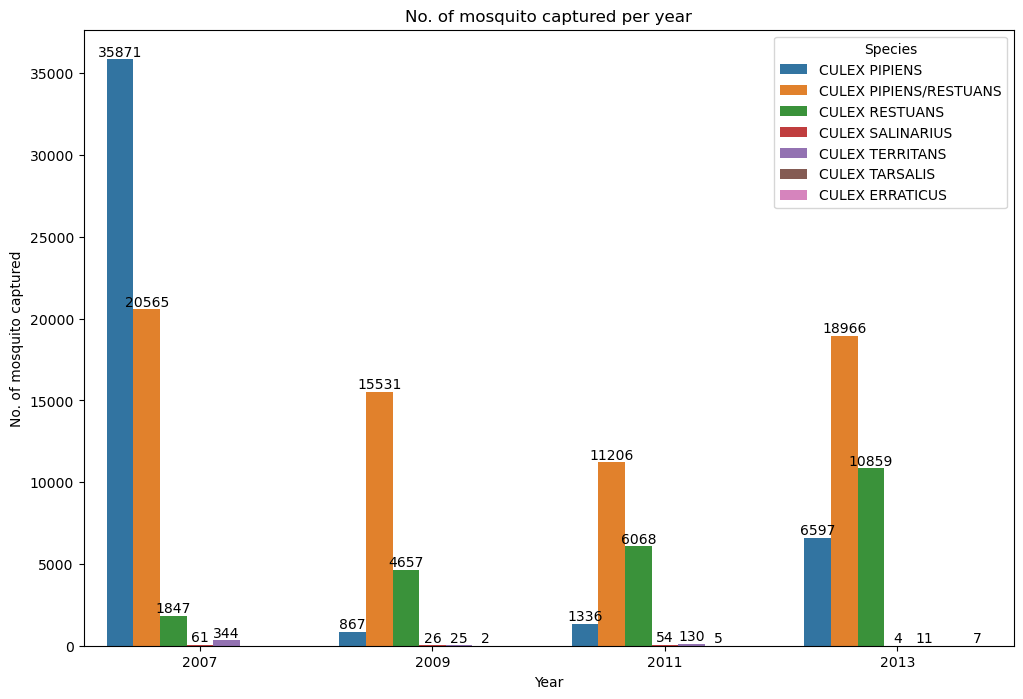

In [118]:
#Plot bar chart for number of mosquito captured per year and species
plt.figure(figsize=(12,8))
ax = sns.barplot(x='Year', y='NumMosquitos', hue='Species', data=year_mozzie)

#Plot data values for each bar
for i in ax.containers:
    ax.bar_label(i,)
plt.title('No. of mosquito captured per year')
plt.xlabel('Year')
plt.ylabel('No. of mosquito captured');

- In 2007, CULEX PIPIENS were the highest number of species caught but dramatically reduced in 2009. 
- On 2009 onwards, CULEX PIPIENS/RESTUANS	 became the highest number of specie caught. 

**Virus carrier Mosquito species**

In [119]:
#Let's identify the mosquito species that contain WNV
species_virus = train[['Species','NumMosquitos','WnvPresent']].groupby(['Species'], as_index = False).sum()

In [120]:
#top virus carrying species 
species_virus.sort_values(by='WnvPresent', ascending=False)

,Species,NumMosquitos,WnvPresent
2,CULEX PIPIENS/RESTUANS,66268,225
1,CULEX PIPIENS,44671,184
3,CULEX RESTUANS,23431,48
0,CULEX ERRATICUS,7,0
4,CULEX SALINARIUS,145,0
5,CULEX TARSALIS,7,0
6,CULEX TERRITANS,510,0


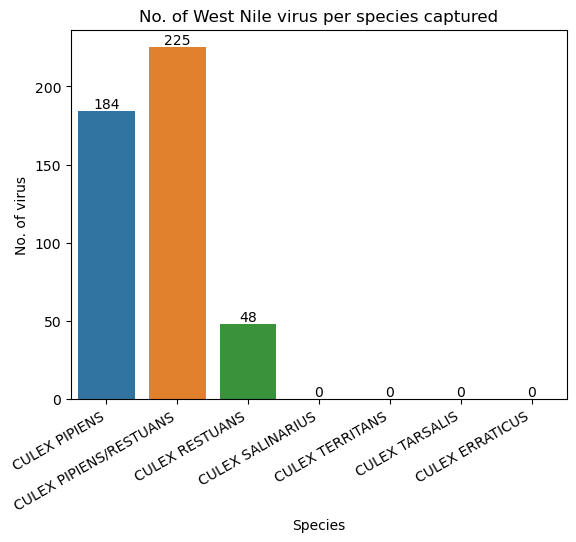

In [121]:
#Plot bar chart for no. of virus per species
ax = sns.barplot(x='Species', y='WnvPresent', data=year_mozzie, ci = None, estimator = sum)
plt.xticks(rotation=30, ha='right')

#Plot data values for each bar
for i in ax.containers:
    ax.bar_label(i,)
plt.title('No. of West Nile virus per species captured')
plt.ylabel('No. of virus');

- WNV were detected in CULEX PIPIENS/RESTUANS, CULEX PIPIENS, and CULEX RESTUANS

**Traps that captured the most WNV mosquitos**

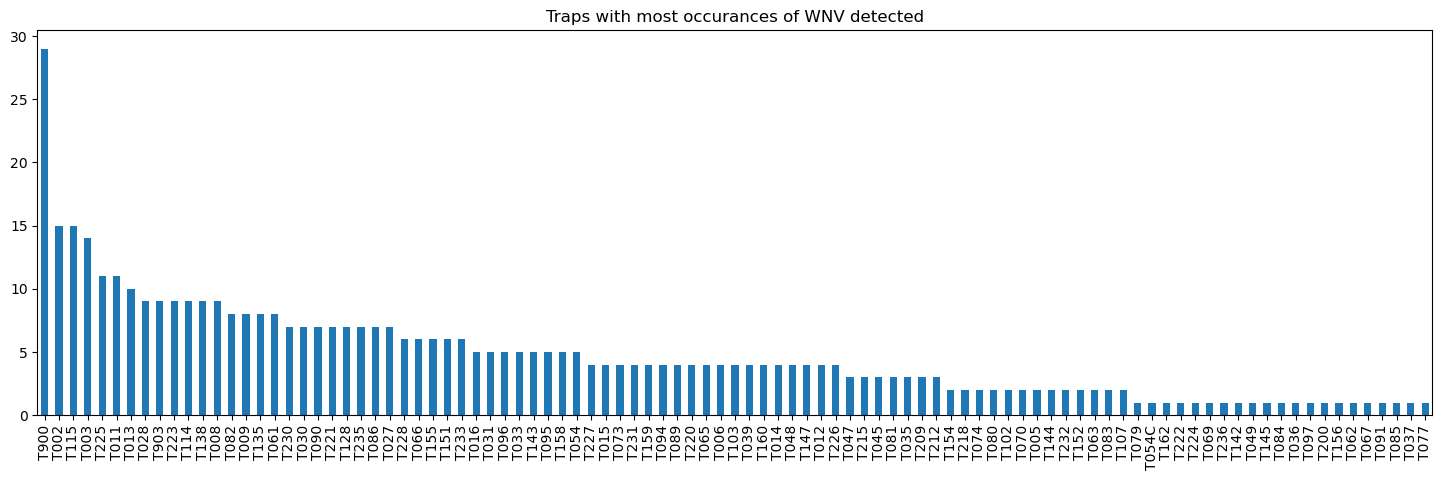

In [122]:
# Plotting a figure to show which traps caught the most WNV positive mosquitoes

plt.figure(figsize=(18, 5))
plt.title("Traps with most occurances of WNV detected")
train["Trap"][train["WnvPresent"] == 1].value_counts().plot(kind="bar");

**Find location of top 5 traps with WNV**

In [125]:
trap_num = ['T900', 'T002', 'T115', 'T003', 'T225']

for i in trap_num:    
    print("Trap ",i,": ",train["Address"][train["Trap"] == i].unique())

Trap  T900 :  ["ORD Terminal 5, O'Hare International Airport, Chicago, IL 60666, USA"]
Trap  T002 :  ['4100 North Oak Park Avenue, Chicago, IL 60634, USA']
Trap  T115 :  ['South Doty Avenue, Chicago, IL, USA']
Trap  T003 :  ['4600 Milwaukee Avenue, Chicago, IL 60630, USA']
Trap  T225 :  ['8200 South Kostner Avenue, Chicago, IL 60652, USA']


- These are top 5 geographical hotspots which tend to most frequently detect WNV bearing mosquitoes.
- These places should be noted for additional mosquito eradication efforts.

**WNV presence per year**

In [53]:
year_virus = train[['Year','WnvPresent']].groupby(['Year'], as_index = False).sum()

In [54]:
year_virus

,Year,WnvPresent
0,2007,189
1,2009,19
2,2011,50
3,2013,199


Text(0, 0.5, 'No. of virus')

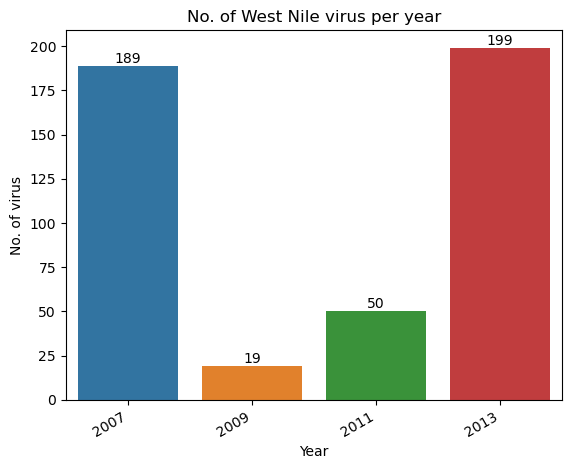

In [55]:
#Plot bar chart for no. of virus per year
ax = sns.barplot(x='Year', y='WnvPresent', data=year_virus, ci = None)
plt.xticks(rotation=30, ha='right')

#Plot data values for each bar
for i in ax.containers:
    ax.bar_label(i,)
plt.title('No. of West Nile virus per year')
plt.xlabel('Year')
plt.ylabel('No. of virus')

In [56]:
month_virus = train[['Month','WnvPresent']].groupby(['Month'], as_index = False).sum()

**WNV presence per month**

Text(0, 0.5, 'No. of virus')

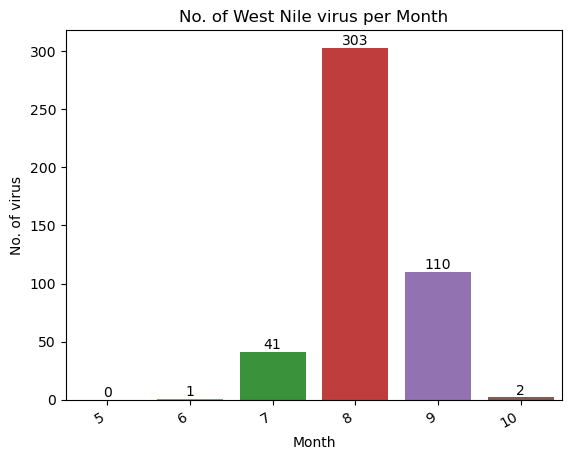

In [57]:
#Plot bar chart for no. of virus per Month
ax = sns.barplot(x='Month', y='WnvPresent', data=month_virus, ci = None, estimator = sum)
plt.xticks(rotation=30, ha='right')

#Plot data values for each bar
for i in ax.containers:
    ax.bar_label(i,)
plt.title('No. of West Nile virus per Month')
plt.xlabel('Month')
plt.ylabel('No. of virus')

- Highest number of WNV is present in August

**WNV presence by Month Year**
<br>- Here's is the breakdown presence of WNV by month and year. WNV presence is largely towards the end of summer

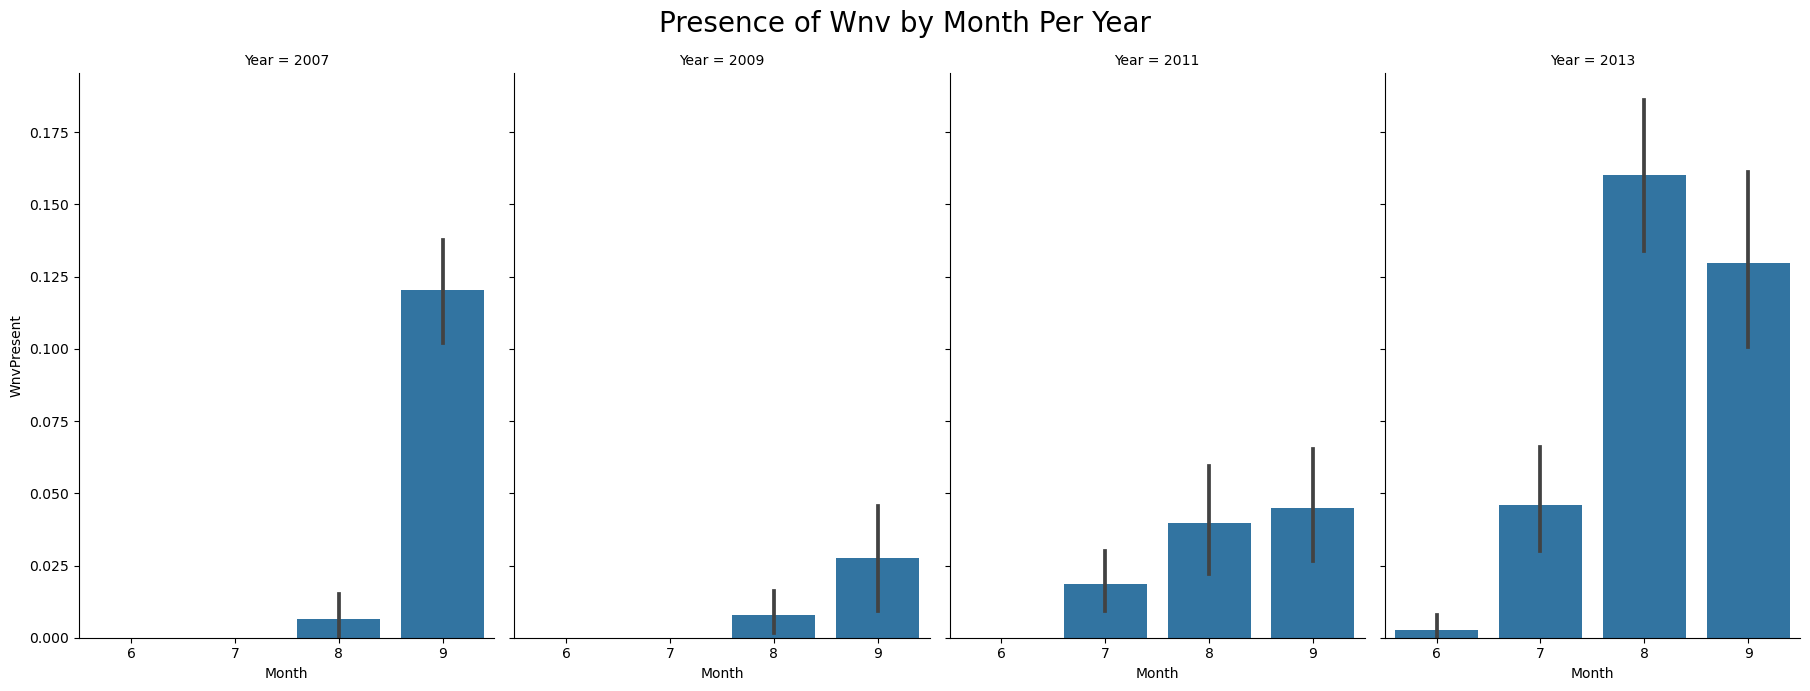

In [58]:
g = sns.FacetGrid(train, col="Year", height=7, aspect=.65)
g.fig.suptitle('Presence of Wnv by Month Per Year', fontsize=20)
g.map_dataframe(sns.barplot, x="Month", y="WnvPresent");

**Weather Stations**
- The weather dataset are based on two different weather stations located in Chicago. We will find the nearest weather station for each of the traps and assign a station to the trap. 

In [59]:
# Weather stations information
weather_stns = {
    'station_1' : {
        'name': 'CHICAGO O\'HARE INTERNATIONAL AIRPORT',
        'latitude': 41.995,
        'longitude': -87.933,
        'elev': 662
    },
    'station_2' : {
        'name': 'CHICAGO MIDWAY INTERNATIONAL AIRPORT',
        'latitude': 41.786,
        'longitude': -87.752,
        'elev': 612
    }
}

In [60]:
import haversine as hs
from haversine import Unit

In [61]:
def get_station(df):
    df['Station'] = np.nan
    # Assign stations coordinates
    stn1 = (41.995, -87.933)
    stn2 = (41.786, -87.752)
    for i in range(len(df)):
        #Get trap coordinates
        trap_loc = (df['Latitude'][i], df['Longitude'][i])
        #Calculate distances between station1 and station 2 in miles
        stn1_dist = hs.haversine(stn1,trap_loc,unit=Unit.MILES)
        stn2_dist = hs.haversine(stn2,trap_loc,unit=Unit.MILES)
        if stn1_dist > stn2_dist:
            df['Station'][i] = 2 #Assign station2
        else:
            df['Station'][i] = 1 #Assign station1

In [62]:
# Apply function to train and test dataset to get the station number
get_station(train)

C:\Users\rohaz\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\rohaz\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [63]:
train.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,WnvPresent,NumMosquitos,Year,Month,Day,Week,Station
0,2007-05-29,"1100 Roosevelt Road, Chicago, IL 60608, USA",CULEX PIPIENS/RESTUANS,11,W ROOSEVELT,T048,"1100 W ROOSEVELT, Chicago, IL",41.867108,-87.654224,8,0,1,2007,5,29,22,2.0
1,2007-05-29,"1100 Roosevelt Road, Chicago, IL 60608, USA",CULEX RESTUANS,11,W ROOSEVELT,T048,"1100 W ROOSEVELT, Chicago, IL",41.867108,-87.654224,8,0,2,2007,5,29,22,2.0
2,2007-05-29,"1100 South Peoria Street, Chicago, IL 60608, USA",CULEX RESTUANS,11,S PEORIA ST,T091,"1100 S PEORIA ST, Chicago, IL",41.862292,-87.648860,8,0,1,2007,5,29,22,2.0
3,2007-05-29,"1100 West Chicago Avenue, Chicago, IL 60642, USA",CULEX RESTUANS,11,W CHICAGO,T049,"1100 W CHICAGO, Chicago, IL",41.896282,-87.655232,8,0,1,2007,5,29,22,2.0
4,2007-05-29,"1500 North Long Avenue, Chicago, IL 60651, USA",CULEX RESTUANS,15,N LONG AVE,T153,"1500 N LONG AVE, Chicago, IL",41.907645,-87.760886,8,0,1,2007,5,29,22,2.0


In [64]:
get_station(test)

C:\Users\rohaz\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\rohaz\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Save the train and test dataset to pickle file

As we will be using the latitude and longitude for the dataset, we will drop the following columns relating to the location for both train and test

In [65]:
# Drop 'Address','Block','Street','AddressNumberAndStreet','AddressAccuracy' from Train dataset
train.drop(['Address','Block','Street','AddressNumberAndStreet','AddressAccuracy'], axis = 1, inplace = True)
# Drop 'Address','Block','Street','AddressNumberAndStreet','AddressAccuracy' from Test dataset
test.drop(['Address','Block','Street','AddressNumberAndStreet','AddressAccuracy'], axis = 1, inplace = True)

In [66]:
train.shape

(8610, 12)

In [67]:
# Save cleaned train to pickle file
train.to_pickle('./data/train_final.pkl')

In [68]:
test.head()

,Id,Date,Species,Trap,Latitude,Longitude,Year,Month,Day,Week,Station
0,1,2008-06-11,CULEX PIPIENS/RESTUANS,T002,41.95469,-87.800991,2008,6,11,24,1.0
1,2,2008-06-11,CULEX RESTUANS,T002,41.95469,-87.800991,2008,6,11,24,1.0
2,3,2008-06-11,CULEX PIPIENS,T002,41.95469,-87.800991,2008,6,11,24,1.0
3,4,2008-06-11,CULEX SALINARIUS,T002,41.95469,-87.800991,2008,6,11,24,1.0
4,5,2008-06-11,CULEX TERRITANS,T002,41.95469,-87.800991,2008,6,11,24,1.0


In [69]:
# Save cleaned test to pickle file
test.to_pickle('./data/test_final.pkl')

In [70]:
# Read pickle file
train = pd.read_pickle('./data/train_final.pkl')